In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV


In [4]:
df=pd.read_csv("../daily_cp_activity_dataset.csv")

In [ ]:
#Indexing and imputing missing values/outliers

In [5]:
df['date']=pd.to_datetime(df['date'])
df.set_index('date',inplace=True)

In [6]:
outliers_courier=df['courier_partners_online'].nlargest(5).index
median_courier=df['courier_partners_online'].median()
for index in outliers_courier:
    df.at[index,'courier_partners_online']=median_courier

In [7]:
df['temperature'].interpolate(method='linear', limit_direction='both', inplace=True)

In [8]:
median_precipitation=df['precipitation'].median()
df['precipitation'].fillna(median_precipitation,inplace=True)

In [10]:
#Normalizing features' values

In [9]:
scaler=MinMaxScaler()
columns_to_scale = ['temperature', 'precipitation','relative_humidity']
df[columns_to_scale]=scaler.fit_transform(df[columns_to_scale])

In [ ]:
#train-test-validate split

In [10]:
# Calculate the number of observations in each set
total_size = len(df)
train_size = int(total_size * 0.8)  # 80% for training
validation_size = int(total_size * 0.1)  # 10% for validation
test_size = total_size - train_size - validation_size  # Remaining 10% for test

# Split the data
train = df[:train_size]
validation = df[train_size:train_size + validation_size]
test = df[train_size + validation_size:]

In [ ]:
#prepare the train/validation/test data

In [15]:
X_train = train.drop('courier_partners_online', axis=1)
y_train = train['courier_partners_online']
X_validation = validation.drop('courier_partners_online', axis=1)
y_validation = validation['courier_partners_online']
X_test = test.drop('courier_partners_online', axis=1)
y_test = test['courier_partners_online']

In [ ]:
#fit the model

In [12]:
# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 3, 5]
}

# Initialize XGBRegressor and GridSearchCV
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror')
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300}
Best score found:  -123.28333843071239


In [ ]:
#predict on validation

In [13]:

best_params = grid_search.best_params_

# Create a new model instance with the best parameters
optimized_model = xgb.XGBRegressor(**best_params)

# Fit the model on the training data
optimized_model.fit(X_train, y_train)
y_pred = optimized_model.predict(X_validation)

In [ ]:
#count the mse

In [14]:
y_pred = optimized_model.predict(X_validation)
mse = mean_squared_error(y_validation, y_pred)
print(f"Mean Squared Error with Optimized Model: {mse}")

Mean Squared Error with Optimized Model: 130.41330315169208


In [1]:
#plot validation Vs predicted

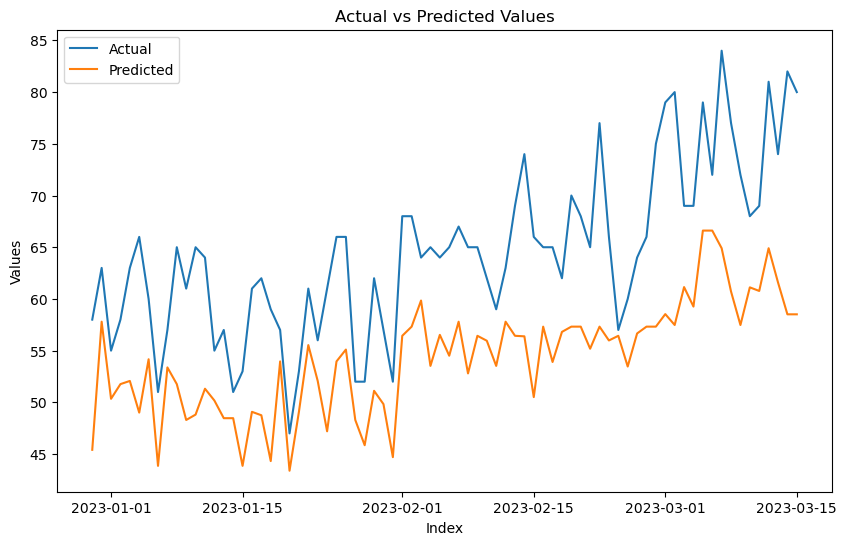

In [16]:
y_pred_series = pd.Series(y_pred, index=y_validation.index)

plt.figure(figsize=(10, 6))
plt.plot(y_validation, label='Actual')
plt.plot(y_pred_series, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

In [ ]:
#check model on test set

Mean Squared Error on Test Data: 197.92829659223548


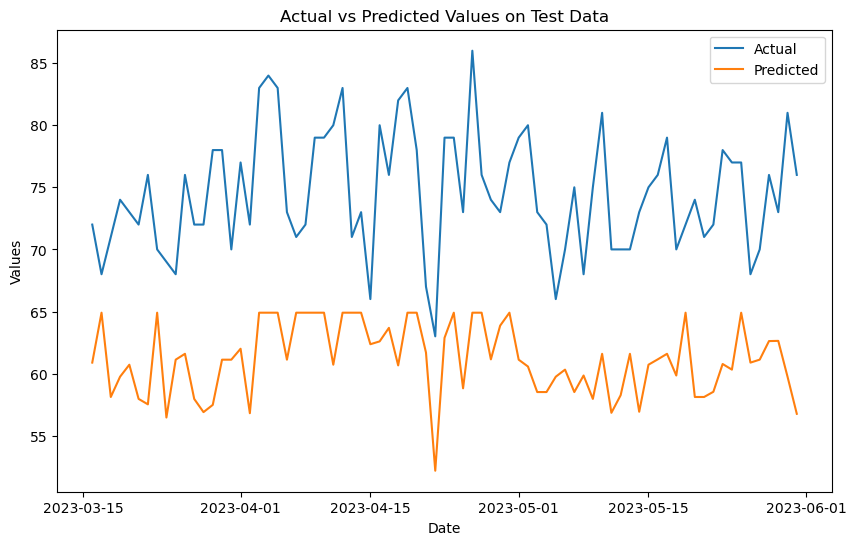

In [17]:
# Make predictions on the test set
y_pred_test = optimized_model.predict(X_test)

# Convert the predictions to a Pandas Series and set its index to match y_test's index
y_pred_test_series = pd.Series(y_pred_test, index=y_test.index)

# Evaluate the model
mse_test = mean_squared_error(y_test, y_pred_test)
print(f"Mean Squared Error on Test Data: {mse_test}")

# Visualize the predictions against actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_test_series, label='Predicted')
plt.title('Actual vs Predicted Values on Test Data')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()